# 第三部分 特征篇（上）

## 特征处理基础方法与实现

In [2]:
import numpy as np

### 定量特征

In [3]:
feature = np.array([1, 2, 3, 4, 5])

#### 1、中心化处理

$ f'_i = f_i - \bar{f} $

In [4]:
feature - feature.mean()

array([-2., -1.,  0.,  1.,  2.])

#### 2、特征缩放

$ f'_i = \frac{f_i - f_{min}}{f_{max} - f_{min}} $

In [5]:
from sklearn.preprocessing import MinMaxScaler
MinMaxScaler().fit_transform(feature.reshape(-1, 1))

array([[0.  ],
       [0.25],
       [0.5 ],
       [0.75],
       [1.  ]])

#### 3、规范化/正则化

In [6]:
from sklearn.preprocessing import normalize

sample = np.array([[1, -1, 2], [2, 1, 0], [0, -1, 1]])
sample_normalized = normalize(sample, norm='l2')
sample_normalized

array([[ 0.40824829, -0.40824829,  0.81649658],
       [ 0.89442719,  0.4472136 ,  0.        ],
       [ 0.        , -0.70710678,  0.70710678]])

In [7]:
# 取第一行验证是否为单位范数
np.square(sample_normalized[0, :]).sum()

1.0000000000000002

#### 4、对数转换

In [8]:
feature = np.array([1, 10, 100, 1000, 10000])
feature_log = np.log(feature)
feature_log

array([0.        , 2.30258509, 4.60517019, 6.90775528, 9.21034037])

In [9]:
# 推广：幂变换/Box-Cox变换
from sklearn.preprocessing import PowerTransformer

X = [[1, 2], [3, 2], [4, 5]]
PowerTransformer().fit_transform(X)

array([[-1.31616039, -0.70710678],
       [ 0.20998268, -0.70710678],
       [ 1.1061777 ,  1.41421356]])

#### 5、特征二值化

In [10]:
import pandas as pd

x = pd.Series([1, 2, 3, 4, 5])
(x>3).astype(int).values

array([0, 0, 0, 1, 1])

### 序数特征

In [11]:
from sklearn.preprocessing import LabelEncoder

x = ['b', 'b', 'a', 'c', 'b']
LabelEncoder().fit_transform(x)

array([1, 1, 0, 2, 1])

### 类别特征

In [12]:
from sklearn.preprocessing import OneHotEncoder

feature = np.array(['b', 'a', 'c'])
OneHotEncoder(sparse=False).fit_transform(feature.reshape(-1, 1))

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

### WOE编码

$ WOE_i = ln(\frac{P_{y1}}{P_{y0}}) = ln(\frac{B_iB}{G_iG}) $

In [13]:
np.random.seed(0)

test_df = pd.DataFrame({
    'x': np.random.choice(['R', 'G', 'B'], 1000),
    'y': np.random.randint(2, size=1000)
})
pd.crosstab(test_df['y'], test_df['x'], margins=True)

x      B    G    R   All
y                       
0    163  165  153   481
1    165  170  184   519
All  328  335  337  1000

In [14]:
def cal_woe(x, y):
    '''
    x, y: pd.Series
          变量x为类别变量，y为0/1
    '''
    t = pd.crosstab(y, x)
    w = t.div(t.sum(axis=1), axis=0)
    # Bad / Good
    return np.log(w.iloc[1, :] / w.iloc[0, :])

cal_woe(test_df['x'], test_df['y'])

x
B   -0.063841
G   -0.046184
R    0.108461
dtype: float64

### 日期特征

In [15]:
class DateTimeProcess:
    def __init__(self, s):
        # 格式化
        self.s = pd.to_datetime(s, errors='coerce')
        self.df = pd.DataFrame()
    
    def data_process(self):
        ''' 衍生日期特征
        return:
            Mth: 月份
            isWeekend: 是否周末。0：否；1：是
            PeriodOfMonth: 1：上旬；2：下旬；3：下旬
        '''
        def _level(d): 
            if d < (1 / 3.0):
                return 1
            elif d > (2 / 3.0):
                return 3
            else:
                return 2 

        self.df['Mth'] = self.s.dt.month
        t = self.s.dt.day * 1.0 / self.s.dt.daysinmonth
        self.df['PeriodOfMonth'] = t.apply(_level)
        # 数据在 0~6 之间，星期一是0，星期日是6
        self.df['isWeekend'] = (self.s.dt.dayofweek >= 5).apply(int)
    
    def time_process(self):
        ''' 衍生时间特征
        return:
            PeriodOfDay: 0：深夜；1：上午；2：下午；3：晚上
        '''
        def _hour(hour):
            if (hour >= 0) & (hour <=6): 
                return 0
            elif (hour > 6) & (hour <=12): 
                return 1
            elif (hour > 12) & (hour <= 18):
                return 2
            else:
                return 3
        
        self.df['PeriodOfDay'] = self.s.dt.hour.apply(_hour)

    def process(self):
        self.data_process()
        self.time_process()
        return self.df

In [16]:
t = pd.Series([
    '2018-07-19T09:38:59.795+08:00'
])
DateTimeProcess(t).process()

Mth  PeriodOfMonth  isWeekend  PeriodOfDay
0    7              2          0            1

## 特征离散化方法和实现

### 等宽和等频离散法

In [17]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

bc = load_breast_cancer()
y = bc.target
X = pd.DataFrame.from_records(data=bc.data, columns=bc.feature_names)
# 转化为df
df = X
df['target'] = y

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use(['science', 'ieee', 'grid', 'muted'])

sns.displot(df['mean radius'], kde=False)

#### 等宽分箱

分隔点的宽度:  

$ w = \frac{max - min}{n} $

In [19]:
value, cutoff = pd.cut(df['mean radius'], bins=8, retbins=True, precision=2)

In [20]:
cutoff

array([ 6.959871,  9.622125, 12.26325 , 14.904375, 17.5455  , 20.186625,
       22.82775 , 25.468875, 28.11    ])

In [21]:
c2 = cutoff.copy()
c2[1: ] - cutoff[ :-1] # 每个分隔点的距离

array([2.662254, 2.641125, 2.641125, 2.641125, 2.641125, 2.641125,
       2.641125, 2.641125])

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '(6.96, 9.62]'),
  Text(1, 0, '(9.62, 12.26]'),
  Text(2, 0, '(12.26, 14.9]'),
  Text(3, 0, '(14.9, 17.55]'),
  Text(4, 0, '(17.55, 20.19]'),
  Text(5, 0, '(20.19, 22.83]'),
  Text(6, 0, '(22.83, 25.47]'),
  Text(7, 0, '(25.47, 28.11]')])

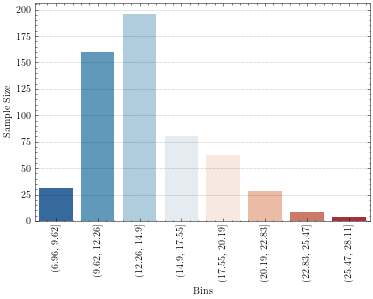

In [22]:
counts = value.value_counts(sort=False)
sns.barplot(x=[str(idx) for idx in counts.index], y=counts, palette="RdBu_r")
plt.xlabel('Bins')
plt.ylabel('Sample Size')
plt.xticks(rotation=90)

#### 等频分箱

In [23]:
value, cutoff = pd.qcut(df['mean radius'], 8, retbins=True)
value.value_counts()

(6.9799999999999995, 10.66]    72
(19.0, 28.11]                  71
(15.78, 19.0]                  71
(14.41, 15.78]                 71
(13.37, 14.41]                 71
(12.47, 13.37]                 71
(11.7, 12.47]                  71
(10.66, 11.7]                  71
Name: mean radius, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '(6.9799999999999995, 10.66]'),
  Text(1, 0, '(10.66, 11.7]'),
  Text(2, 0, '(11.7, 12.47]'),
  Text(3, 0, '(12.47, 13.37]'),
  Text(4, 0, '(13.37, 14.41]'),
  Text(5, 0, '(14.41, 15.78]'),
  Text(6, 0, '(15.78, 19.0]'),
  Text(7, 0, '(19.0, 28.11]')])

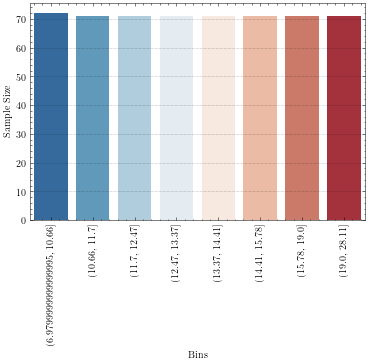

In [24]:
counts = value.value_counts(sort=False)
sns.barplot(x=[str(idx) for idx in counts.index], y=counts, palette="RdBu_r")
plt.xlabel('Bins')
plt.ylabel('Sample Size')
plt.xticks(rotation=90)

In [25]:
# 正常情况，1/2属于一箱，3/4属于一箱，5/6属于一箱
s1 = pd.Series([1, 2, 3, 4, 5, 6])
value, cutoff = pd.qcut(s1, 3, retbins=True)
value.value_counts()

(4.333, 6.0]      2
(2.667, 4.333]    2
(0.999, 2.667]    2
dtype: int64

In [26]:
# 当某一特定值出现次数特别多时
s2 = pd.Series([1, 2, 3, 4, 5, 6, 6, 6, 6])
value, cutoff = pd.qcut(s2, 3, duplicates='drop', retbins=True)
value.value_counts()

(3.667, 6.0]      6
(0.999, 3.667]    3
dtype: int64

#### 基于sklearn决策树离散化

In [27]:
from sklearn.tree import DecisionTreeClassifier

# max_depth=3，表示进行3次划分构造3层的树结构
def dt_enptropy_cut(x, y, feature, max_depth=3, criterion='entropy'): # gini
    dt = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth)
    dt.fit(x.values.reshape(-1, 1), y)
    qts = dt.tree_.threshold[np.where(dt.tree_.children_left > -1)]
    if qts.shape[0] == 0:
        qts = np.array([np.median(data[:, feature])])
    else:
        qts = np.sort(qts)
    return qts

In [28]:
cutoff = dt_enptropy_cut(df['mean radius'], df['target'], ['mean radius'], max_depth=3, criterion='entropy')
cutoff = cutoff.tolist()
bins = [np.round(x, 3) for x in cutoff]
# 注意，该数据序列中只给出6个点，相当于只分了7箱
bins.insert(0, -np.inf)
bins.append(np.inf)
bins

[-inf, 10.945, 13.095, 13.705, 15.045, 17.8, 17.88, inf]

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '(-inf, 10.945]'),
  Text(1, 0, '(10.945, 13.095]'),
  Text(2, 0, '(13.095, 13.705]'),
  Text(3, 0, '(13.705, 15.045]'),
  Text(4, 0, '(15.045, 17.8]'),
  Text(5, 0, '(17.8, 17.88]'),
  Text(6, 0, '(17.88, inf]')])

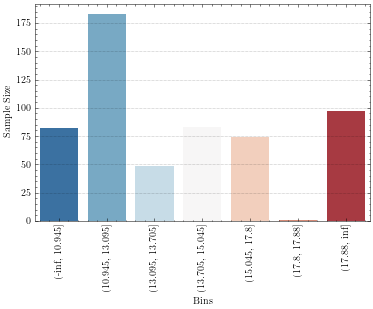

In [29]:
value = pd.cut(df['mean radius'], bins=bins)
counts = value.value_counts(sort=False)
sns.barplot(x=[str(idx) for idx in counts.index], y=counts, palette="RdBu_r")
plt.xlabel('Bins')
plt.ylabel('Sample Size')
plt.xticks(rotation=90)

#### 信息熵分箱算法实现

1. 计算原始信息熵

2. 对于数据中的每个潜在分割点计算以该点划分后各部分的信息熵

3. 计算信息（熵）增益

4. 选择信息增益最大值对应的分割点

5. 递归地对每个分箱后的部分执行2/3/4，直到满足终止条件位置。终止条件一般为：

    - 到达指定的分箱数

    - 当信息增益小于某一阈值

    - 其他经验条件

In [30]:
import numpy as np
import pandas as pd

class entropy:
    '''计算离散随机变量的熵
    x, y: pd.Series 类型
    '''
    @staticmethod
    def entropy(x):
        '''信息熵'''
        p = x.value_counts(normalize=True)
        p = p[p > 0]
        e = -(p * np.log2(p)).sum()
        return e
    
    @staticmethod
    def cond_entropy(x, y):
        '''条件熵'''
        p = y.value_counts(normalize=True)
        e = 0
        for yi in y.unique():
            e += p[yi] * entropy.entropy(x[y == yi])
        return e
    
    @staticmethod
    def info_gain(x, y):
        '''信息增益'''
        g = entropy.entropy(x) - entropy.cond_entropy(x, y)
        return g


def cut_by_entropy(df, label, loop=3, min_count=5, margin=0.01):
    '''停止准则：
    1. 已到循环次数
    2. 信息增益增加小于阈值（用最小熵，不便定义熵值的大小）
    '''
    assert len(df.columns) == 2, 'not support'

    def _is_too_small(df, min_count):
        '''待分裂的区间样本数要求'''
        return df.shape[0] < min_count
    
    def _is_only_one_class(df, label):
        '''待分箱的序列已经是同一类别了'''
        return len(df[label].unique().tolist()) == 1

    def _get_best_points(df, label, feature_col, loop=3, min_count=5, margin=0.01):
        if loop == 0 or _is_only_one_class(df, label) or _is_too_small(df, min_count):
            print('loop end.')
            return [None]
        else:
            # 计算信息增益
            gain, max_p = get_max_gain_point(df, label, feature_col)
            print('max_p={}, gain={}'.format(max_p, gain))
            # 信息增益小于指定阈值时停止分箱
            if gain < margin:
                return [None]
            
            # 左闭，右开
            left = df.loc[df[feature_col] < max_p, :]
            right = df.loc[df[feature_col] >= max_p, :]

            if _is_only_one_class(left, label) or _is_only_one_class(right, label) or _is_too_small(left, min_count) or _is_too_small(right, min_count):
                print('     不满足要求，该分隔点去除')
                return [None]


            # 递归分箱
            return [max_p] + \
                _get_best_points(left, label, feature_col, loop - 1, margin) + \
                _get_best_points(right, label, feature_col, loop - 1, margin)
    
    feature_col = [aa for aa in df.columns.tolist() if aa != label][0]
    points = _get_best_points(df, label, feature_col, loop, margin)
    points = [p for p in points if p is not None]
    points = list(set(points))
    points.sort()
    return points


def get_max_gain_point(df, label, feature_col):
    '''
    分箱后，使用离散方法计算信息增益
    注意这里的for实现效率较低，实践中请先粗分类
    '''
    gain, max_p = -1, -1
    ps = df[feature_col].unique().tolist()
    ps.sort()

    if len(ps) < 2:
        return -1, None
    
    for pp in ps:
        tmp = (df[feature_col] < pp).astype(int)
        g = entropy.info_gain(df[label], tmp)
        if g > gain:
            gain = g
            max_p = pp
    return gain, max_p

In [31]:
cutoff = cut_by_entropy(df[['mean radius', 'target']], 'target', min_count=5, margin=0.001)
cutoff.insert(0, -np.inf)
cutoff.append(np.inf)
cutoff

max_p=15.05, gain=0.4629862529990506
max_p=13.11, gain=0.07679344919283099
max_p=10.95, gain=0.02701401365980899
     不满足要求，该分隔点去除
max_p=13.71, gain=0.015068640676456302
loop end.
loop end.
max_p=17.91, gain=0.08068906189021191
     不满足要求，该分隔点去除


[-inf, 13.11, 13.71, 15.05, inf]

(array([0, 1, 2, 3]),
 [Text(0, 0, '(-inf, 13.11]'),
  Text(1, 0, '(13.11, 13.71]'),
  Text(2, 0, '(13.71, 15.05]'),
  Text(3, 0, '(15.05, inf]')])

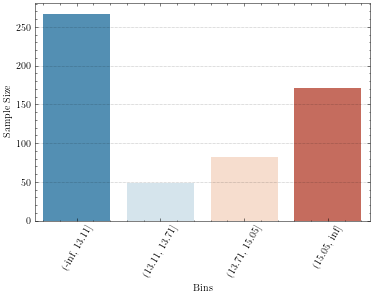

In [32]:
value = pd.cut(df['mean radius'], bins=cutoff)
counts = value.value_counts(sort=False)
sns.barplot(x=[str(idx) for idx in counts.index], y=counts, palette="RdBu_r", data=df)
plt.xlabel('Bins')
plt.ylabel('Sample Size')
plt.xticks(rotation=60)

### Best-KS 分箱原理与实现

In [33]:
from scipy.stats import ks_2samp

def ks2(actual, pred):
    get_ks = lambda pred, actual: ks_2samp(pred[actual == 1], pred[actual != 1]).statistic
    return get_ks(pred, actual)

In [34]:
ks2(df['target'], df['mean radius'])

0.728621637334179

#### Best-KS 离散化

1. 指定分箱数量的阈值等停止条件
2. 从小到大排序标签值
3. 计算累计正负标签占比的差，找出KS最大的位置对应的特征值，记为B点，称为最佳分割点，在B点将特征值序列分为左右两个部分
4. 递归步骤2：B点左右的数据按同样的方法进行分割，直到满足停止的条件

In [35]:
class CalKS:
    @staticmethod
    def pivot(df, label):
        """
        1、计算数据透视表-pivot
        2、只支持二分类
        paramters
        ----------
        df: 带标签的DataFrame,共两列数据
        label:带label的列名
        return
        ------
        DataFrame—数据透视表
        """
        assert len(df.columns) == 2, 'not support'
        df_ = df.copy()
        feature_col = [aa for aa in df_.columns.tolist() if aa != label][0]

        return pd.pivot_table(
            df_,
            index=[feature_col],
            columns=[label],
            aggfunc=len,
            fill_value=0)

    @staticmethod
    def cal_ks(df, is_pivot=True, label=None):
        '''
        paramters
        ----------
        df:    待计算的两列数据：x,y
        label：label列名
        计算方法：
            abs(表签0累计用户占比 - 表签1累计用户占比)
        return
        ------
        DataFrame—KS统计表
        '''
        pivot_df = df.copy()
        if is_pivot is False:
            pivot_df = CalKS.pivot(df, label)

        # 二分类（0,1）实际就是  [0, 1]
        label_value = pivot_df.columns.tolist()

        # 表签0的数量
        count_0 = pivot_df[label_value[0]].sum()
        pivot_df['cum_percent_1'] = \
        pivot_df[label_value[0]].cumsum() / count_0

        # 表签1的数量
        count_1 = pivot_df[label_value[1]].sum()
        pivot_df['cum_percent_2'] = \
        pivot_df[label_value[1]].cumsum() / count_1

        pivot_df['KS'] = pivot_df['cum_percent_1'].sub(
            pivot_df['cum_percent_2']).abs()
        print('KS:', pivot_df["KS"].max())
        return pivot_df

def bestks_cut(df, label, loop=3, min_count=0.01, return_combine=True):
    # 去除了空值
    pivot_df = CalKS.pivot(df, label)
    if 0.0 < min_count < 1.0:
        min_count = int(min_count * df.shape[0])
    min_count = max(min_count, int(0.01 * df.shape[0]))
    assert min_count > 1, 'bestks_cut:wrong min_count:{}'.format(min_count)
    return get_bestks_points(pivot_df, loop, min_count)


def get_bestks_points(df, loop=3, min_count=5):
    cols = df.columns.tolist()

    # 是否为空箱
    def _is_null(df):
        return df.shape[0] == 0

    # 是否全0或全1的标签
    def _is_only_one_class(df, cols):
        return df[cols[0]].sum() == 0 or df[cols[1]].sum() == 0

    # 箱内的样本数量是否太少
    def _is_too_small(df, cols, min_count):
        return (df[cols[0]].sum() + df[cols[1]].sum()) < min_count

    def _split_bestks(df, loop=3, min_count=5):
        '''
        df:透视表格式
        '''
        if loop == 0 or _is_null(df) or _is_only_one_class(
                df, cols) or _is_too_small(df, cols, min_count):
            return [None]
        else:
            max_p = CalKS.cal_ks(df).idxmax()['KS']
            left = df.loc[df.index < max_p, :]
            right = df.loc[df.index >= max_p, :]

            # 如果这个max_p
            if _is_null(left) or _is_null(right) or \
                _is_only_one_class(left, cols) or \
                _is_only_one_class(right, cols) or \
                _is_too_small(left, cols, min_count) or \
                _is_too_small(right, cols, min_count):
                return [None]

            # 左右子树递归
            return [max_p] + _split_bestks(left, loop - 1,min_count) \
                            + _split_bestks(right, loop - 1, min_count)

    points = _split_bestks(df, loop, min_count)
    points = [p for p in points if p is not None]
    points = list(set(points))
    return points

In [36]:
cutoff = bestks_cut (df[['mean radius','target']],'target')
cutoff.insert(0, -np.inf)
cutoff.append(np.inf)
cutoff.sort()
cutoff

KS: 0.728621637334179
KS: 0.47553282182438195
KS: 0.35488813974869754
KS: 0.16237402015677493
KS: 0.6433747412008282
KS: 0.24090909090909093
KS: 0.829059829059829


[-inf, 11.75, 13.08, 13.7, 15.04, 15.27, 16.84, 17.85, inf]

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '(-inf, 11.75]'),
  Text(1, 0, '(11.75, 13.08]'),
  Text(2, 0, '(13.08, 13.7]'),
  Text(3, 0, '(13.7, 15.04]'),
  Text(4, 0, '(15.04, 15.27]'),
  Text(5, 0, '(15.27, 16.84]'),
  Text(6, 0, '(16.84, 17.85]'),
  Text(7, 0, '(17.85, inf]')])

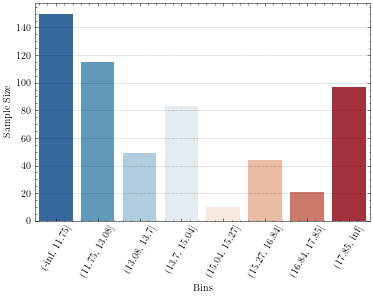

In [37]:
value = pd.cut(df['mean radius'], bins=cutoff)
counts = value.value_counts(sort=False)
sns.barplot(x=[str(idx) for idx in counts.index], y=counts, palette="RdBu_r", data=df)
plt.xlabel('Bins')
plt.ylabel('Sample Size')
plt.xticks(rotation=60)

### 卡方分箱原理与实现

#### 卡方检验

In [38]:
from scipy.stats import chi2_contingency

obs = np.array([[25, 50], [30, 15]])
# 注意，默认有校准
chi2, p, dof, ex = chi2_contingency(obs, correction=False)
print('chi2: {}, p_value: {}, dof: {}, ex: {}'.format(chi2, p, dof, ex))

chi2: 12.587412587412587, p_value: 0.0003883534014852554, dof: 1, ex: [[34.375 40.625]
 [20.625 24.375]]


#### 卡方离散化

减少了精度，便于演示和快速计算和查看

Step 1: 计算卡方值

In [48]:
from scipy import stats
def stats_chi2(arr,correction=False):
    try:
        # 便于演示，此处统一未使用校准，实际中可根据频数精确控制
        s=stats.chi2_contingency(arr,correction=correction)
    except ValueError:
    # 返回0认为0的组应该进行合并
        print('Data Error')
        return 0
    return s[0]

Step 2: 粗分箱，此处简单通过数值精度和等分12份实现粗分箱来便于演示

In [40]:
x = df['mean radius'].round(0)

# 便于演示，先等分12箱
value,cutoff = \
pd.cut(x,bins=12,retbins=True,precision=0,include_lowest=True)

# 便于演示将初始分隔点取整
cutoff = cutoff.round(0)
cutoff

array([ 7.,  9., 10., 12., 14., 16., 18., 19., 21., 23., 24., 26., 28.])

In [43]:
# 再次分箱
value, cutoff = pd.cut(x, bins=cutoff, retbins=True, precision=0, include_lowest=True)

Step 3: 生成列联表，其数据结构如下：

In [44]:
freq_tab = pd.crosstab(value, df['target'])
freq_tab

target         0    1
mean radius          
(6.0, 9.0]     0   28
(9.0, 10.0]    0   37
(10.0, 12.0]   9  141
(12.0, 14.0]  31  117
(14.0, 16.0]  50   32
(16.0, 18.0]  42    2
(18.0, 19.0]  22    0
(19.0, 21.0]  40    0
(21.0, 23.0]  10    0
(23.0, 24.0]   2    0
(24.0, 26.0]   3    0
(26.0, 28.0]   3    0

In [46]:
# 转化为numpy多维数组
freq = freq_tab.values

Step 4: 计算各相邻箱的卡方值：

算法数据结构设计，使用二维数组记录各相邻组的卡方值

In [52]:
cvs = np.array([])
for i in range(len(freq) - 1):
    cvs = np.append(cvs, stats_chi2(freq[i: i + 2]))

Data Error
Data Error
Data Error
Data Error
Data Error
Data Error
[ 0.          2.33224719 14.31978033 37.05919675 17.27738586  1.03125
  0.          0.          0.          0.          0.        ]


Step 5: 设定卡方阈值，常使用0.90, 0.95, 0.99的置信度

In [53]:
# 此处以95%的置信度（自由度为类数目-1）设定阈值。
from scipy.stats import chi2

threshold = chi2.isf(0.05, df=1)
threshold

3.8414588206941285

Step 6:设置合并的条件：小于阈值时进行合并。

In [56]:
_c1 = lambda x: x < threshold

Step 7: 循环直到卡方值不满足阈值条件

In [54]:
def chi2_merge_core(cvs, freq, cutoffs, minidx):
    '''卡方合并逻辑
    实现合并最小卡方值的相邻组（合并到左边组）
    '''
    print('最小卡方值索引:',minidx,'；分割点:',cutoffs)
    # minidx后一箱合并到前一组
    tmp = freq[minidx] + freq[minidx + 1]
    freq[minidx] = tmp
    # 删除minidx后一组
    freq = np.delete(freq, minidx + 1, 0)
    # 删除对应的分隔点
    cutoffs = np.delete(cutoffs, minidx + 1, 0)
    cvs = np.delete(cvs, minidx, 0)

    # 更新前后两个组的卡方值，其他部分卡方值未变化
    if minidx <= (len(cvs) - 1):
        cvs[minidx] = stats_chi2(freq[minidx:minidx + 2])
    if minidx - 1 >= 0:
        cvs[minidx - 1] = stats_chi2(freq[minidx - 1:minidx + 1])
    return cvs, freq, cutoffs

In [57]:
while _c1(cvs.min()):
    cvs, freq, cutoff = chi2_merge_core(cvs, freq, cutoff, cvs.argmin())

最小卡方值索引: 0 ；分割点: [ 7.  9. 10. 12. 14. 16. 18. 19. 21. 23. 24. 26. 28.]
最小卡方值索引: 5 ；分割点: [ 7. 10. 12. 14. 16. 18. 19. 21. 23. 24. 26. 28.]
Data Error
最小卡方值索引: 5 ；分割点: [ 7. 10. 12. 14. 16. 18. 21. 23. 24. 26. 28.]
Data Error
最小卡方值索引: 5 ；分割点: [ 7. 10. 12. 14. 16. 18. 23. 24. 26. 28.]
Data Error
最小卡方值索引: 5 ；分割点: [ 7. 10. 12. 14. 16. 18. 24. 26. 28.]
Data Error
最小卡方值索引: 5 ；分割点: [ 7. 10. 12. 14. 16. 18. 26. 28.]
最小卡方值索引: 4 ；分割点: [ 7. 10. 12. 14. 16. 18. 28.]


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '(7.0, 10.0]'),
  Text(1, 0, '(10.0, 12.0]'),
  Text(2, 0, '(12.0, 14.0]'),
  Text(3, 0, '(14.0, 16.0]'),
  Text(4, 0, '(16.0, 28.0]')])

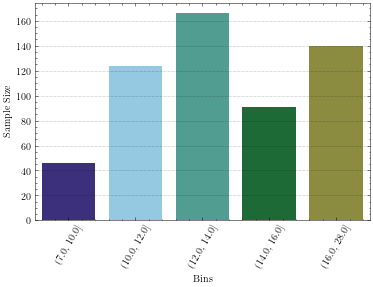

In [59]:
value = pd.cut(df['mean radius'], bins=cutoff)
counts = value.value_counts(sort=False)
sns.barplot(x=[str(idx) for idx in counts.index], y=counts, data=df)
plt.xlabel('Bins')
plt.ylabel('Sample Size')
plt.xticks(rotation=60)